In [38]:
import numpy as np
import warnings
warnings.simplefilter('ignore')
import pandas as pd
%pylab inline
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.regression import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression, LassoCV, Lasso 

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.metrics.regression import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression, LassoCV, Lasso 
from sklearn.svm import SVC
from sklearn.metrics import f1_score

classifiers = [LogisticRegression(), 
               RandomForestClassifier(), 
               SVC()]
classifiers_name = ["LogisticRegression",
               "RandomForestClassifier", 
               "SVC"]

In [17]:
xls_file = pd.ExcelFile('retail_vol_ccy_w_rt.xlsx')
df = xls_file.parse('Total')
df.head()

,Date,vol_tot,vol_rub,vol_ccy,expo_tot,portf_gr,expo_rub,expo_ccy,npl_tot,npl_rub,npl_ccy,rubusd,wage,wage_gr,rt3m,dGPD,d_dec,d_jan,unp,cpi
0,2009-04-01,456779.2,424697.2,32082.0,3848399.0,0.000000,3341053.6,507345.4,180597.6,155980.0,24617.6,33.9032,18009,0.000000,16.53,-0.035002,0,0,8.3,100.7
1,2009-05-01,228701.0,216410.3,12290.7,3791289.5,-0.014840,3300033.5,491256.0,193421.9,166553.5,26868.4,32.9740,18007,-0.000111,16.04,-0.035002,0,0,8.3,100.6
2,2009-06-01,221268.3,212818.6,8449.7,3722873.1,-0.018046,3266609.3,456263.8,202671.2,176069.2,26602.0,30.9843,19247,0.068862,12.49,-0.035002,0,0,8.3,100.6
3,2009-07-01,266435.9,256395.6,10040.3,3683033.9,-0.010701,3232124.6,450909.3,209446.2,182799.5,26646.7,31.0385,18872,-0.019484,11.81,-0.065562,0,0,8.3,100.6
4,2009-08-01,232492.2,221958.4,10533.8,3667260.9,-0.004283,3218173.3,449087.6,217713.4,190062.3,27651.1,31.1533,18335,-0.028455,11.89,-0.065562,0,0,8.3,100.0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], yearfirst=True)

In [16]:
df['d_dec'].value_counts()

0    103
Name: d_dec, dtype: int64

In [11]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)

In [ ]:
df.sort_values?

In [ ]:
df.shift

In [ ]:
df['npl_gr'] = df['npl_tot'] - df['npl_tot'].

In [ ]:
plt.plot(df['vol_tot'])
plt.plot(df['expo_tot'])
plt.plot(df['npl_tot'])
plt.show()

In [ ]:
plt.plot(df['rubusd'])
plt.plot(df['rt3m'])
plt.plot(df['wage']/300)
plt.show()

In [31]:
predictors = list(set(['rubusd','wage_gr','rt3m','dGPD','d_dec','d_jan','unp' , 'cpi']))#'wage',

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0D4B2590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0DA758B0>]], dtype=object)

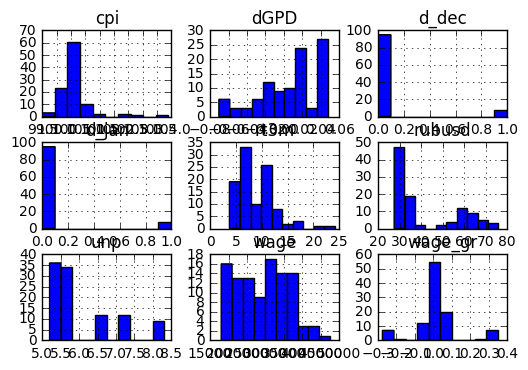

In [19]:
df[predictors].hist()

Пока берем в качестве обучающей выборки всю выборку

In [55]:
X_train = df[predictors]
y_train = df['portf_gr']

X_test = df[predictors].copy()
y_test = df['portf_gr'].copy()

Масштабируем

In [33]:
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_train = pd.DataFrame(X_train, columns = df[predictors].columns)

Смотрим на корреляции признаков

In [56]:
corr = df[predictors].corr()
corr

,d_dec,rt3m,wage_gr,d_jan,cpi,dGPD,unp,rubusd
d_dec,1.000000,-0.027643,0.734719,-0.084211,0.128044,-0.005812,0.038185,0.003313
rt3m,-0.027643,1.000000,-0.083105,0.084558,0.355682,-0.487584,-0.178049,0.641749
wage_gr,0.734719,-0.083105,1.000000,-0.675175,-0.167010,0.000807,0.064783,-0.022971
d_jan,-0.084211,0.084558,-0.675175,1.000000,0.445296,0.016195,-0.068288,0.023526
cpi,0.128044,0.355682,-0.167010,0.445296,1.000000,0.051022,-0.099750,0.057178
dGPD,-0.005812,-0.487584,0.000807,0.016195,0.051022,1.000000,-0.455573,-0.353770
unp,0.038185,-0.178049,0.064783,-0.068288,-0.099750,-0.455573,1.000000,-0.428949
rubusd,0.003313,0.641749,-0.022971,0.023526,0.057178,-0.353770,-0.428949,1.000000


In [25]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
forest = RandomForestRegressor(n_estimators=1000, max_depth = 5,
                                random_state=42)
forest.fit(X_train, y_train)
test_pred = forest.predict(X_test)

In [58]:
forest = RandomForestRegressor(n_estimators=1000, max_depth = 5,
                                random_state=42).fit(X_train, y_train)

features = pd.DataFrame(forest.feature_importances_,
                        index=X_train.columns,columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)

features

,Importance
dGPD,0.748904
rubusd,0.107269
rt3m,0.092161
wage_gr,0.022910
cpi,0.019174
unp,0.008312
d_jan,0.001032
d_dec,0.000239


In [30]:
forest = RandomForestRegressor(n_estimators=1000, max_depth = 5,
                                random_state=42).fit(X_train, y_train)

features = pd.DataFrame(forest.feature_importances_,
                        index=X_train.columns,columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)

features

,Importance
dGPD,0.739463
rubusd,0.097427
rt3m,0.070091
wage,0.050277
wage_gr,0.020010
cpi,0.015613
unp,0.006156
d_jan,0.000837
d_dec,0.000125


In [59]:
forest.score(X_train, y_train)

0.94016903918896644

In [60]:
print(mean_squared_error(forest.predict(X_train), y_train))
print(abs(np.mean(cross_val_score(forest, X_train, y_train, scoring='mean_squared_error', n_jobs=-1))))

1.21603486829e-05
0.00012862637381


Нормируем выборку

In [40]:
X_train.head()

,d_dec,rt3m,wage_gr,d_jan,cpi,dGPD,unp,rubusd
0,-0.290191,2.085327,-0.120777,-0.290191,0.195819,-1.333206,2.38862,-0.536487
1,-0.290191,1.952141,-0.121738,-0.290191,0.017329,-1.333206,2.38862,-0.598368
2,-0.290191,0.987220,0.475400,-0.290191,0.017329,-1.333206,2.38862,-0.730874
3,-0.290191,0.802390,-0.289457,-0.290191,0.017329,-2.302573,2.38862,-0.727265
4,-0.290191,0.824135,-0.367126,-0.290191,-1.053611,-2.302573,2.38862,-0.719620


In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [42]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled.head()

,d_dec,rt3m,wage_gr,d_jan,cpi,dGPD,unp,rubusd
0,-0.290191,2.085327,-0.120777,-0.290191,0.195819,-1.333206,2.38862,-0.536487
1,-0.290191,1.952141,-0.121738,-0.290191,0.017329,-1.333206,2.38862,-0.598368
2,-0.290191,0.987220,0.475400,-0.290191,0.017329,-1.333206,2.38862,-0.730874
3,-0.290191,0.802390,-0.289457,-0.290191,0.017329,-2.302573,2.38862,-0.727265
4,-0.290191,0.824135,-0.367126,-0.290191,-1.053611,-2.302573,2.38862,-0.719620


In [62]:
linreg = LinearRegression(n_jobs=-1)
#linreg.fit(X_train_scaled, y_train)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [63]:
#print(mean_squared_error(linreg.predict(X_train_scaled), y_train))
print(mean_squared_error(linreg.predict(X_train), y_train))

5.13278964967e-05


In [64]:
linreg_coef = pd.DataFrame(np.c_[linreg.coef_, np.abs(linreg.coef_)], index=df[predictors].columns, 
                           columns=['Coeff.', 'Coeff.abs'])
linreg_coef.sort_values(by='Coeff.abs', ascending=False)

,Coeff.,Coeff.abs
dGPD,0.255716,0.255716
wage_gr,-0.042642,0.042642
d_dec,0.015209,0.015209
d_jan,-0.005874,0.005874
cpi,-0.003394,0.003394
unp,-0.002529,0.002529
rt3m,-0.000609,0.000609
rubusd,-0.000247,0.000247


In [65]:
test_l_pred = linreg.predict(X_test)

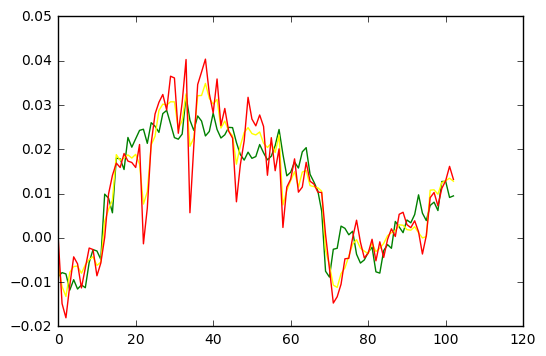

In [66]:
plt.plot(test_l_pred, label='Predicted', c='green')
plt.plot(test_pred, label='Predicted', c='yellow')
plt.plot(y_train, label='Actual', c='red')
plt.show()    
    

In [67]:
lasso1 = Lasso(alpha=0.01, random_state=7)
#lasso1.fit(X_train_scaled, y_train)
lasso1.fit(X_train, y_train)
lasso1.coef_

array([ 0.        , -0.00085879, -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.00028675])

In [68]:
lasso1_coef = pd.DataFrame(np.c_[lasso1.coef_, np.abs(lasso1.coef_)], index=df[predictors].columns, 
                           columns=['Coeff.', 'Coeff.abs'])
lasso1_coef.sort_values(by='Coeff.abs', ascending=False)

,Coeff.,Coeff.abs
rt3m,-0.000859,0.000859
rubusd,-0.000287,0.000287
d_dec,0.000000,0.000000
wage_gr,-0.000000,0.000000
d_jan,0.000000,0.000000
cpi,-0.000000,0.000000
dGPD,0.000000,0.000000
unp,-0.000000,0.000000


In [ ]:
alphas = np.linspace(0.1, 10, 200)
lasso_cv = LassoCV(alphas=alphas, 
                   cv=5, random_state=7)
lasso_cv.fit(X_train_scaled, y_train)

In [ ]:
lasso_cv_coef = pd.DataFrame(np.c_[lasso_cv.coef_, np.abs(lasso_cv.coef_)], index=df[predictors].columns,  
                           columns=['Coeff.', 'Coeff.abs'])
lasso_cv_coef.sort_values(by='Coeff.abs', ascending=False)

In [72]:
#print(mean_squared_error(lasso_cv.predict(X_train_scaled), y_train))
print(mean_squared_error(lasso_cv.predict(X_train), y_train))

0.000203245084452


In [ ]:
####пример модели
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation


def preProcess():
    df= pd.read_csv('C:/Users/X/Desktop/Managerial_and_Decision_Economics_2013_Video_Games_Dataset.csv',encoding ='ISO-8859-1')
    #drop non EA
    df = df[df['EA'] ==1]
    #change categorical variables
    le = LabelEncoder()
    nonnumeric_columns=['Console','Title','Publisher','Genre']
    for feature in nonnumeric_columns:
        df[feature] = le.fit_transform(df[feature])
    #set dataset and target variables
    dataset =df.ix[:, df.columns != 'US Sales (millions)']
    target = df['US Sales (millions)']

    trainx, testx, trainy, testy = cross_validation.train_test_split(
        dataset, target, test_size=0.3, random_state=0)
    #attempt to fix error?
    trainx=np.array(trainx)
    trainy = np.asarray(trainy, dtype="float")
    return trainx,testx,trainy,testy

def classifier():
    model =  ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
    model.fit(trainx,trainy)
    return model.score(testx,testy)


trainx,testx,trainy,testy=preProcess()